In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(1, '/secure/projects/tacco/')
import tacco as tc

In [3]:
sys.path.insert(1, '/secure/projects/HTAPP_MBC/src/spatial')
from spatial_utils import *

In [4]:
combined_dir=out_dir_base+"/combined_all/"
os.makedirs(combined_dir, exist_ok=True)

In [5]:
sample_sheet=pd.read_csv(codeDir+"/meta/sampletracking_HTAPP_MBC_spatial.csv")

In [6]:
#sc sample annotation
sc_samples=pd.read_excel(codeDir+"/meta/clinical features2.xlsx")
sc_samples['sample']=sc_samples['htapp_id']+'-'+sc_samples['htapp_caseid']

In [7]:
sc_samples.head()

ccpm_id  ccpm_id_long              sample  htapp   htapp_id htapp_caseid  \
0      260        300260  HTAPP-225-SMP-6756  HTAPP  HTAPP-225     SMP-6756   
1      289        300289  HTAPP-983-SMP-7659  HTAPP  HTAPP-983     SMP-7659   
2      294        300294  HTAPP-589-SMP-2860  HTAPP  HTAPP-589     SMP-2860   
3      294        300294  HTAPP-589-SMP-2851  HTAPP  HTAPP-589     SMP-2851   
4      360        300360  HTAPP-231-SMP-6758  HTAPP  HTAPP-231     SMP-6758   

     method site_biopsy receptors_biopsy metastatic_presentation  \
0  snRNAseq      Breast    ER+/PR+/HER2-                 De novo   
1  scRNAseq       Liver    ER+/PR+/HER2+                 De novo   
2  snRNAseq       Liver    ER+/PR-/HER2-               Recurrent   
3  snRNAseq       Brain    ER+/PR-/HER2+               Recurrent   
4  snRNAseq       Liver    ER+/PR-/HER2-               Recurrent   

  biopsy_days_after_metastasis  \
0                          846   
1                         1466   
2                          823   
3                          900   
4                          675   

                                   histology_breast  \
0                        Invasive lobular carcinoma   
1  Invasive ductal carcinoma with mucinous features   
2                         Invasive ductal carcinoma   
3                         Invasive ductal carcinoma   
4                         Invasive ductal carcinoma   

  known hereditary predisposition    treatment_status  \
0                             NaN        on-treatment   
1                             ATM  between treatments   
2                             NaN        on-treatment   
3                             NaN        on-treatment   
4                             NaN  between treatments   

     treatment_current_class treatment_most_recent_class  
0                  Endocrine                   Endocrine  
1              off-treatment                Chemotherapy  
2  Endocrine + HER2-targeted   Endocrine + HER2-targeted  
3                  Endocrine                   Endocrine  
4              off-treatment               Immunotherapy

In [8]:
#These identifiers are set as defaults in many functions. If names are changed, this has to be adapted when calling the functions.
ct_column='cell_type'
sm_methods=["slide_seq","merfish","merfish_bin","codex","exseq","exseq_bin"] #spatial mathod names are hard-coded for now because some methods need special treatments. Can be fixed by giving eatch method it's own variable.
sc_method="scRNAseq"
all_methods=[sc_method,*sm_methods]
all_methods

['scRNAseq',
 'slide_seq',
 'merfish',
 'merfish_bin',
 'codex',
 'exseq',
 'exseq_bin']

In [9]:
run_samples=list(filter(lambda a: not a in [''], list(sample_sheet['sample'].unique()))) 
run_samples

['HTAPP-944-SMP-7479',
 'HTAPP-895-SMP-7359',
 'HTAPP-880-SMP-7179',
 'HTAPP-878-SMP-7149',
 'HTAPP-812-SMP-8239',
 'HTAPP-514-SMP-6760',
 'HTAPP-982-SMP-7629',
 'HTAPP-997-SMP-7789',
 'HTAPP-917-SMP-4531',
 'HTAPP-853-SMP-4381',
 'HTAPP-313-SMP-932',
 'HTAPP-330-SMP-1082',
 'HTAPP-783-SMP-4081',
 'HTAPP-364-SMP-1321',
 'HTAPP-213-SMP-6752']

In [10]:
sc_samples=sc_samples.loc[sc_samples['sample'].isin(run_samples)][['sample','method','receptors_biopsy','site_biopsy']].set_index('sample')

In [11]:
sc_samples

method receptors_biopsy site_biopsy
sample                                                   
HTAPP-944-SMP-7479  snRNAseq    ER+/PR-/HER2-       Liver
HTAPP-514-SMP-6760  snRNAseq    ER-/PR-/HER2-      Axilla
HTAPP-895-SMP-7359  snRNAseq    ER+/PR+/HER2-       Liver
HTAPP-982-SMP-7629  scRNAseq    ER+/PR+/HER2-       Liver
HTAPP-213-SMP-6752  snRNAseq    ER-/PR-/HER2-  Chest wall
HTAPP-878-SMP-7149  snRNAseq    ER+/PR-/HER2-      Axilla
HTAPP-880-SMP-7179  snRNAseq    ER+/PR+/HER2-       Liver
HTAPP-364-SMP-1321  scRNAseq    ER+/PR-/HER2+       Liver
HTAPP-783-SMP-4081  scRNAseq    ER+/PR-/HER2-      Breast
HTAPP-853-SMP-4381  scRNAseq    ER+/PR+/HER2-       Liver
HTAPP-917-SMP-4531  scRNAseq    ER-/PR-/HER2-       Liver
HTAPP-313-SMP-932   scRNAseq    ER-/PR-/HER2+       Liver
HTAPP-330-SMP-1082  scRNAseq    ER+/PR+/HER2-       Liver
HTAPP-997-SMP-7789  scRNAseq    ER+/PR-/HER2-       Liver
HTAPP-812-SMP-8239  scRNAseq    ER-/PR-/HER2-      Axilla

In [12]:
adatas_combined=pd.Series([[] for i in range(len(all_methods))],index=all_methods,dtype=object) 
#add combined scRNAseq that was produced in the MERFISH analysis 
adatas_combined['scRNAseq']=sc.read_h5ad(out_dir_base+"/combined_merfish/scRNAseq.h5ad")
for method in sm_methods:
    adatas_combined[method]=sc.read(combined_dir+"/"+method+".h5ad",compression="gzip")

In [13]:
adatas_combined

scRNAseq       [[[View of AnnData object with n_obs × n_vars ...
slide_seq      [[[View of AnnData object with n_obs × n_vars ...
merfish        [[[View of AnnData object with n_obs × n_vars ...
merfish_bin    [[[View of AnnData object with n_obs × n_vars ...
codex          [[[View of AnnData object with n_obs × n_vars ...
exseq          [[[View of AnnData object with n_obs × n_vars ...
exseq_bin      [[[View of AnnData object with n_obs × n_vars ...
dtype: object

In [14]:
for method in sm_methods:
    adatas_combined[method].obsm['OT'].fillna(0,inplace=True)
    adatas_combined[method].obsm['RCTD'].fillna(0,inplace=True)
    adatas_combined[method].obsm['OT_max'].fillna(0,inplace=True)

for method in all_methods:    
    for col in sc_samples.columns:
        adatas_combined[method].obs[col]=adatas_combined[method].obs['sample'].map(sc_samples[col])

In [15]:
#add bins per method
for method in sm_methods:
    tc.utils.bin(adatas_combined[method].obs,bin_size=100,bin_keys=["x_100","y_100"]);
    tc.utils.hash(adatas_combined[method].obs,keys=["x_100","y_100","sample"],hash_key=["bin_100"]);

In [16]:
adatas_combined_mal=adatas_combined.copy()
for method in all_methods:
    print(method)
    adatas_combined_mal[method].obs=adatas_combined_mal[method].obs.rename(columns={"OT":"cell_type"})
    sub=adatas_combined_mal[method][adatas_combined_mal[method].obs["cell_type"].isin({"MBC","MBC_stem-like","MBC_neuronal"})].copy()
    adatas_combined_mal[method]=anndata.AnnData(X=sub.obsm["counts"],obsm=sub.obsm,obs=sub.obs,var=pd.DataFrame(index=sub.uns["counts_var"]))
    

scRNAseq
slide_seq
merfish
merfish_bin
codex
exseq
exseq_bin


In [17]:
for method in all_methods:
    print(method)
    adatas_combined_mal[method]=create_scanpy(adatas_combined_mal[[method]],var_genes=None,batch_key='sample',redo=False,process=True,mode=None)

scRNAseq
Batch aware HVG selection failed. Running without batch_key.


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'receptors_biopsy' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'site_biopsy' as categorical


slide_seq
Batch aware HVG selection failed. Running without batch_key.


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'receptors_biopsy' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'site_biopsy' as categorical


merfish


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'receptors_biopsy' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'site_biopsy' as categorical


merfish_bin


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'receptors_biopsy' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'site_biopsy' as categorical


codex


/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'receptors_biopsy' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'site_biopsy' as categorical
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical


exseq


Trying to set attribute `.obs` of view, copying.
... storing 'receptors_biopsy' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'site_biopsy' as categorical
/secure/src/anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.


exseq_bin


... storing 'receptors_biopsy' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'site_biopsy' as categorical


In [18]:
for method in all_methods:
    adatas_combined_mal[method].write(combined_dir+"/"+method+"_mal.h5ad",compression="gzip")

In [12]:
adatas_combined_mal=pd.Series([[] for i in range(len(all_methods))],index=all_methods,dtype=object) 
for method in all_methods:
    adatas_combined_mal[method]=sc.read(combined_dir+"/"+method+"_mal.h5ad",compression="gzip")

In [13]:
matplotlib.rcParams['figure.dpi'] = low_dpi

/secure/projects/tacco/tacco/plots/_plots.py:872: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=-1)[...,None]


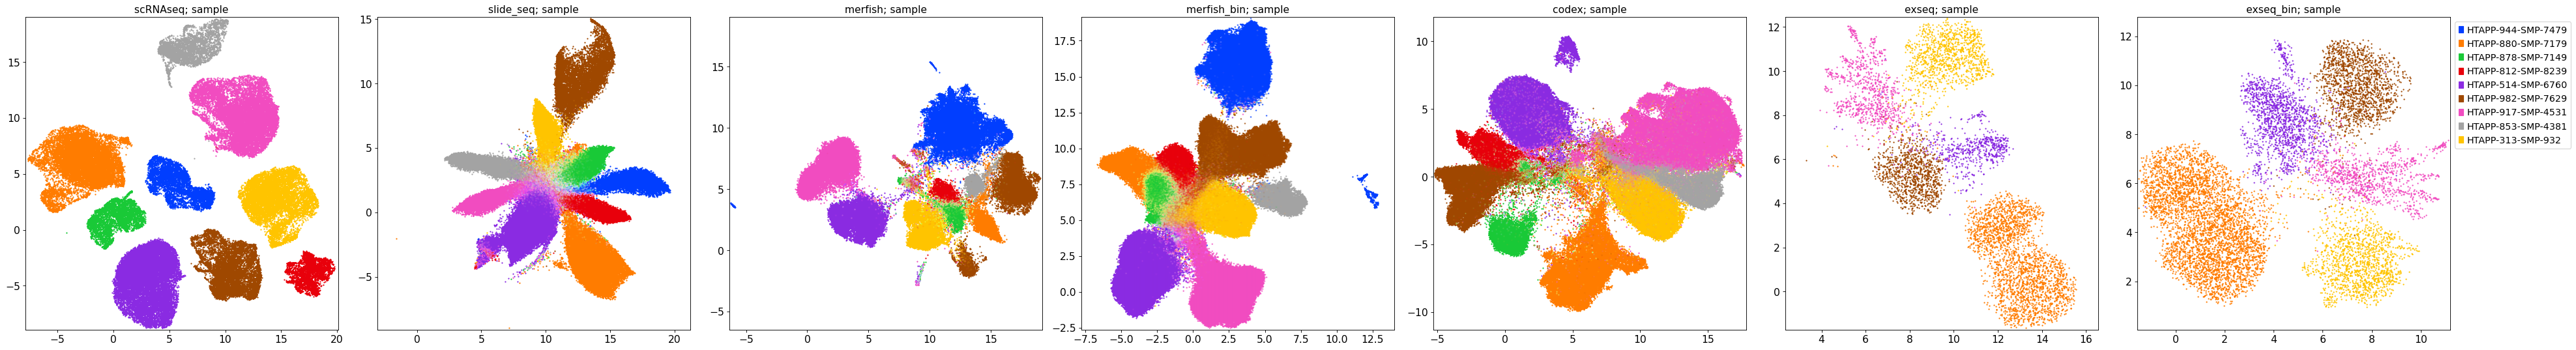

In [15]:
fig = tc.pl.scatter(adatas_combined_mal, keys=['sample'],joint=True,position_key="X_umap",axsize=(6,6), share_scaling=False, padding=0.75);
fig.savefig(combined_dir+'/UMAP_mal_sample.pdf',bbox_inches='tight')

/secure/projects/tacco/tacco/plots/_plots.py:872: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=-1)[...,None]


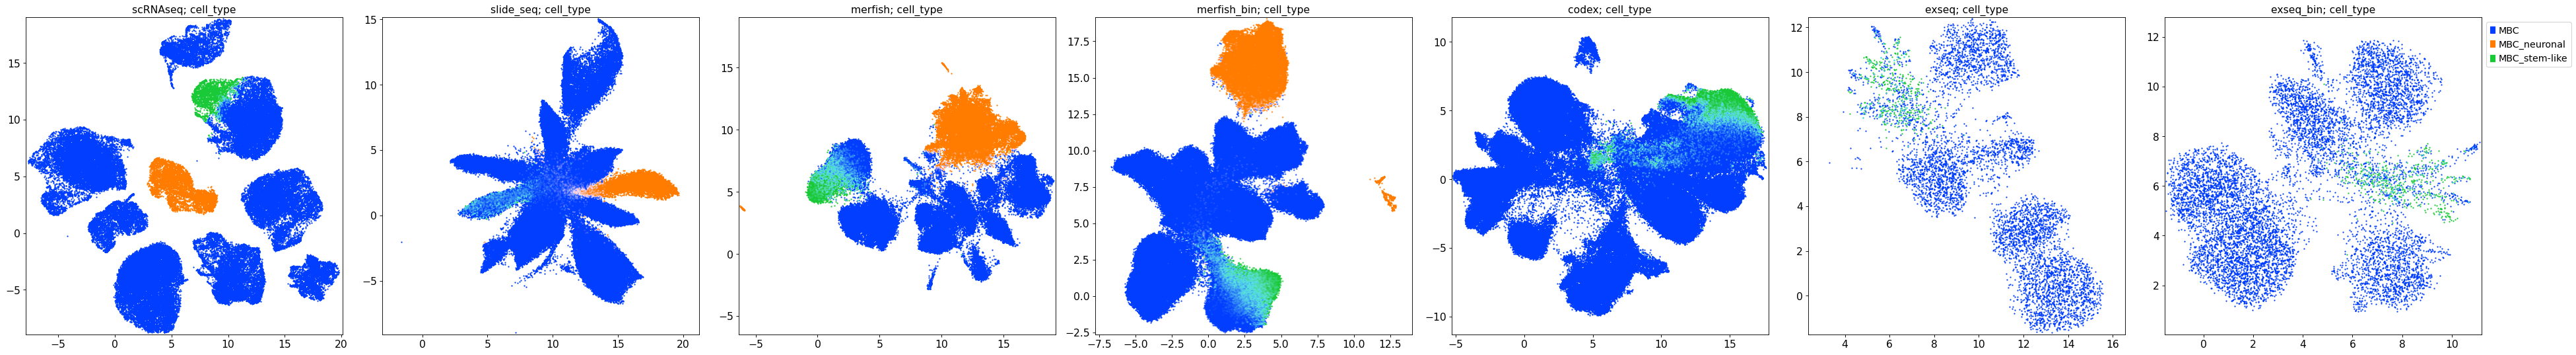

In [16]:
fig = tc.pl.scatter(adatas_combined_mal, keys=['cell_type'],joint=True,position_key="X_umap",axsize=(6,6), share_scaling=False, padding=0.75);
fig.savefig(combined_dir+'/UMAP_mal_ct.pdf',bbox_inches='tight')

In [41]:
pr_fresh=pd.read_csv(os.path.dirname(os.path.dirname(projectDir))+"/phase2/analysis/05_LIGER/compartments_fresh/Malignant_noRP_lambda_40_k_20_LIGER_topGenes.tsv",sep="\t")
pr_frozen=pd.read_csv(os.path.dirname(os.path.dirname(projectDir))+"/phase2/analysis/05_LIGER/compartments_frozen/Malignant_noRP_lambda_40_k_20_LIGER_topGenes.tsv",sep="\t")

In [42]:
fresh_merfish = list(set(pr_fresh['Factor_16_u']).intersection(set(adatas_combined_mal['merfish'].var.index)))
fresh_codex = list(set(pr_fresh['Factor_16_u']).intersection(set(adatas_combined_mal['codex'].var.index)))

In [43]:
#fresh_merfish=set(fresh_merfish).difference(set(['APOE']))
fresh_merfish

['TCF4',
 'COL4A1',
 'BGN',
 'COL1A2',
 'FN1',
 'COL1A1',
 'ACTA2',
 'MYL9',
 'HSPG2',
 'TIMP1',
 'VIM',
 'THY1',
 'APOE',
 'COL3A1',
 'DCN',
 'LUM',
 'TAGLN',
 'TPM2',
 'GNG11',
 'COL4A2']

In [44]:
fresh_codex

['VIM', 'THY1', 'COL4A2']

In [45]:
bg_merfish=list(adatas_combined_mal['merfish'].var.index)

In [46]:
for method in all_methods:
    adatas_combined_mal[method]=adatas_combined_mal[method][adatas_combined_mal[method].obs['sample'].isin(adatas_combined_mal['merfish'].obs['sample'].cat.categories)].copy()
    sc.tl.score_genes(adatas_combined_mal[method],gene_pool=bg_merfish,gene_list=fresh_merfish,score_name="EMT_fresh",use_raw=True)
    if method != "scRNAseq":
        adatas_combined_mal[method].obs['sample_repl']=adatas_combined_mal[method].obs["sample"].astype(str)+"_"+adatas_combined_mal[method].obs["replicate"].astype(str)

In [47]:
for method in all_methods:
    adatas_combined_mal[method].write(combined_dir+"/"+method+"_mal.h5ad",compression="gzip")

... storing 'sample_repl' as categorical
... storing 'sample_repl' as categorical
... storing 'sample_repl' as categorical
... storing 'sample_repl' as categorical
... storing 'sample_repl' as categorical
... storing 'sample_repl' as categorical


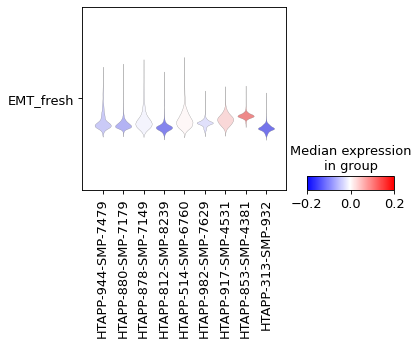

In [23]:
fig=sc.pl.stacked_violin(adatas_combined_mal['scRNAseq'],var_names=['EMT_fresh'],groupby='sample',rotation=90,swap_axes=True,
                         figsize=(5,3),cmap="bwr",vmax=0.2,vmin=-0.2,return_fig=True)
fig.savefig(combined_dir+'/violin_scRNAseq_mal_EMT.pdf',bbox_inches='tight')

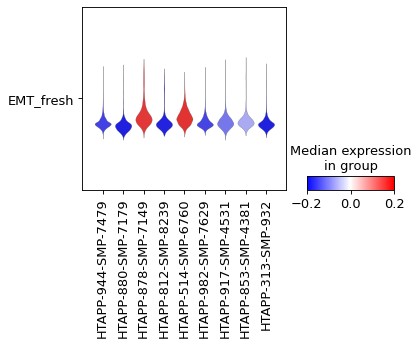

In [24]:
fig=sc.pl.stacked_violin(adatas_combined_mal['merfish'],var_names=['EMT_fresh'],groupby='sample',rotation=90,swap_axes=True,
                         figsize=(5,3),cmap="bwr",vmax=0.2,vmin=-0.2,return_fig=True)
fig.savefig(combined_dir+'/violin_merfish_mal_EMT.pdf',bbox_inches='tight')

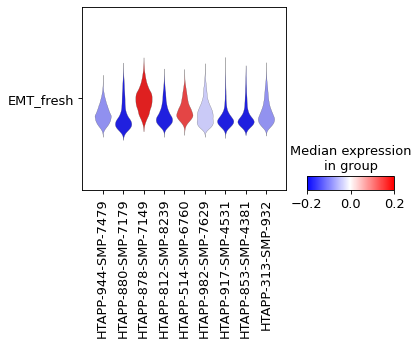

In [26]:
fig=sc.pl.stacked_violin(adatas_combined_mal['merfish_bin'],var_names=['EMT_fresh'],groupby='sample',rotation=90,swap_axes=True,
                         figsize=(5,3),cmap="bwr",vmax=0.2,vmin=-0.2,return_fig=True)
fig.savefig(combined_dir+'/violin_merfish_bin_mal_EMT.pdf',bbox_inches='tight')

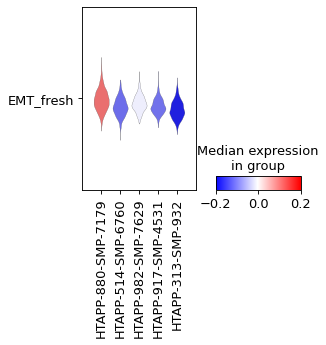

In [32]:
fig=sc.pl.stacked_violin(adatas_combined_mal['exseq'],var_names=['EMT_fresh'],groupby='sample',rotation=90,swap_axes=True,
                         figsize=(3.5,3),cmap="bwr",vmax=0.2,vmin=-0.2,return_fig=True)
fig.savefig(combined_dir+'/violin_exseq_mal_EMT.pdf',bbox_inches='tight')

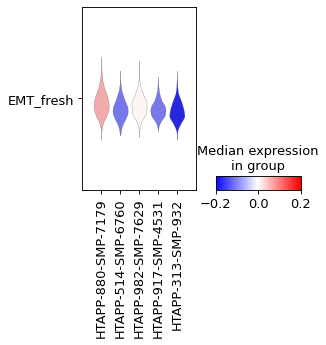

In [33]:
fig=sc.pl.stacked_violin(adatas_combined_mal['exseq_bin'],var_names=['EMT_fresh'],groupby='sample',rotation=90,swap_axes=True,
                         figsize=(3.5,3),cmap="bwr",vmax=0.2,vmin=-0.2,return_fig=True)
fig.savefig(combined_dir+'/violin_exseq_bin_mal_EMT.pdf',bbox_inches='tight')

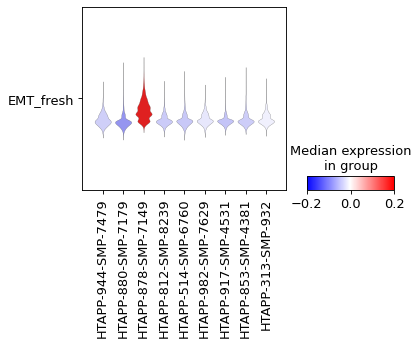

In [27]:
fig=sc.pl.stacked_violin(adatas_combined_mal['slide_seq'],var_names=['EMT_fresh'],groupby='sample',rotation=90,swap_axes=True,
                         figsize=(5,3),cmap="bwr",vmax=0.2,vmin=-0.2,return_fig=True)
fig.savefig(combined_dir+'/violin_slide_seq_mal_EMT.pdf',bbox_inches='tight')

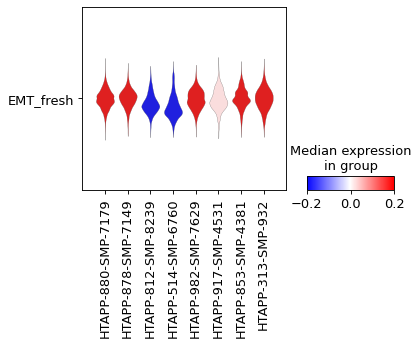

In [28]:
fig=sc.pl.stacked_violin(adatas_combined_mal['codex'],var_names=['EMT_fresh'],groupby='sample',rotation=90,swap_axes=True,
                         figsize=(5,3),cmap="bwr",vmax=0.2,vmin=-0.2,return_fig=True)
fig.savefig(combined_dir+'/violin_codex_mal_EMT.pdf',bbox_inches='tight')

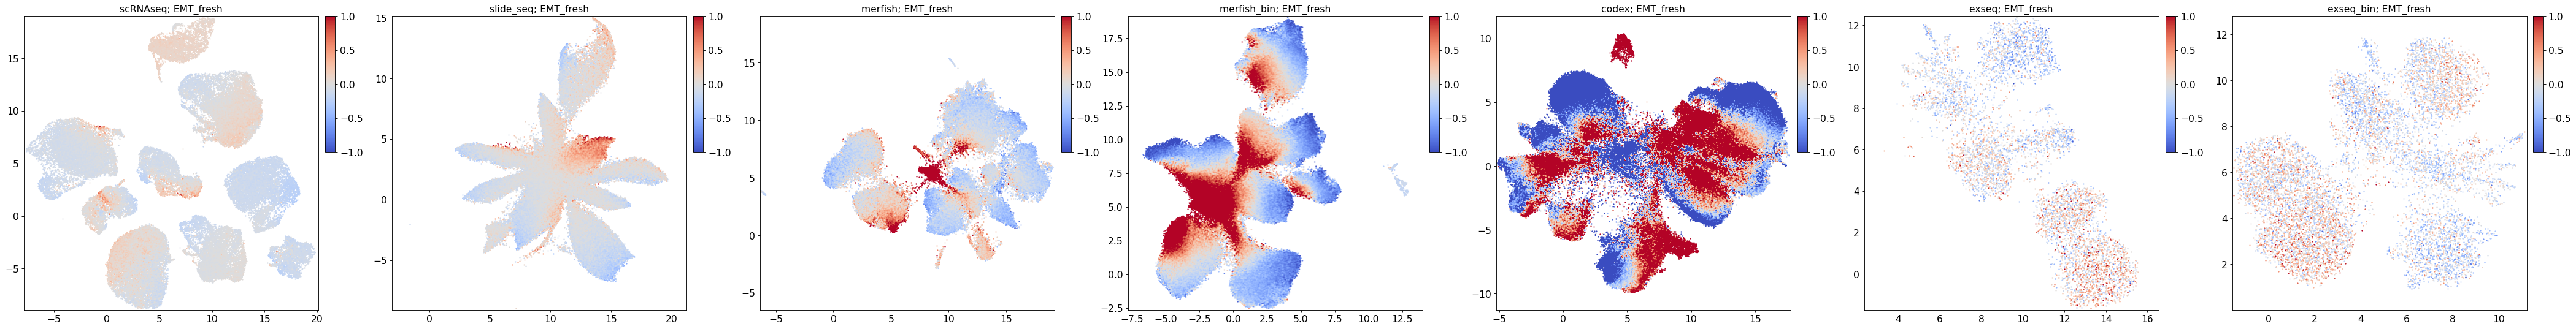

In [41]:
fig = tc.pl.scatter(adatas_combined_mal, keys=['EMT_fresh'],joint=True,position_key="X_umap",cmap="coolwarm",cmap_vmin_vmax=[-1,1],axsize=(6,6), share_scaling=False, padding=1.5);
fig.savefig(combined_dir+'/UMAP_mal_EMT.pdf',bbox_inches='tight')

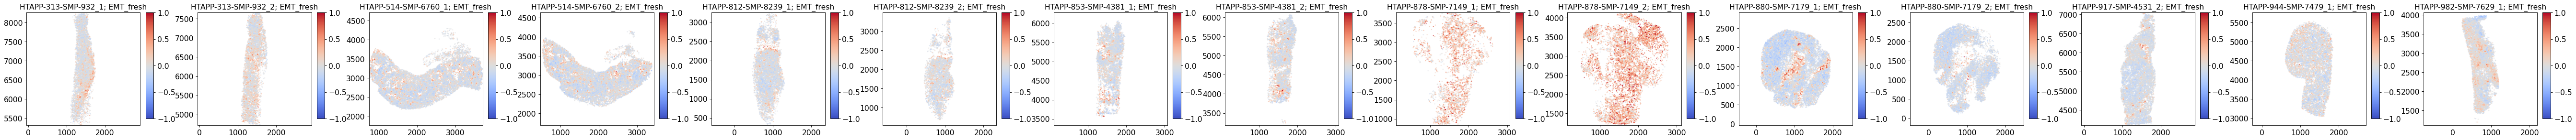

In [42]:
fig=tc.pl.scatter(adatas_combined_mal['slide_seq'],group_key='sample_repl',keys=['EMT_fresh'],cmap="coolwarm",cmap_vmin_vmax=[-1,1],joint=True,padding=1.5,point_size=2,axsize=1e-3);
fig.savefig(combined_dir+'/scatter_slide_seq_mal_EMT.pdf',bbox_inches='tight')

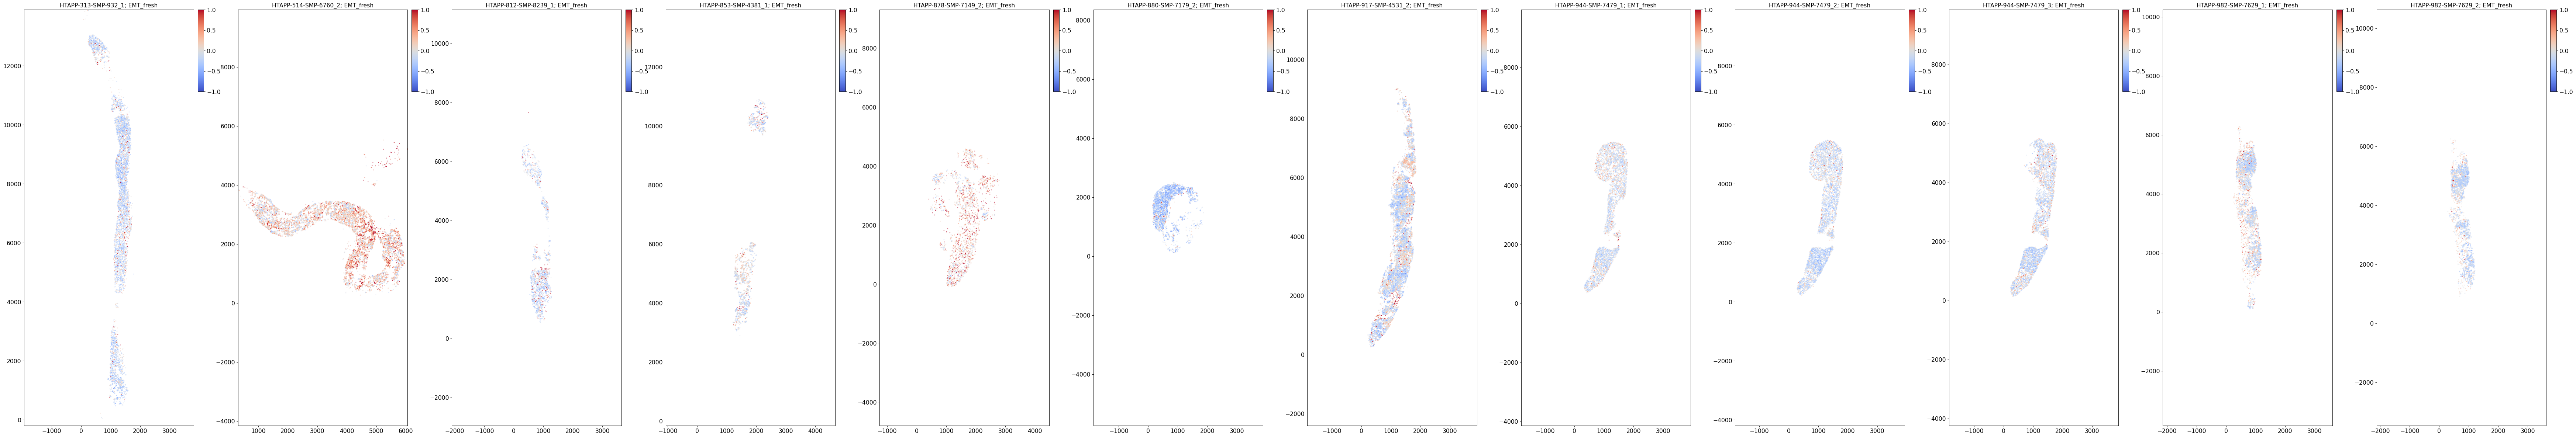

In [45]:
fig=tc.pl.scatter(adatas_combined_mal['merfish'],group_key='sample_repl',keys=['EMT_fresh'],cmap="coolwarm",cmap_vmin_vmax=[-1,1],joint=True,padding=1.5,point_size=2,axsize=1e-3);
fig.savefig(combined_dir+'/scatter_merfish_mal_EMT.pdf',bbox_inches='tight')

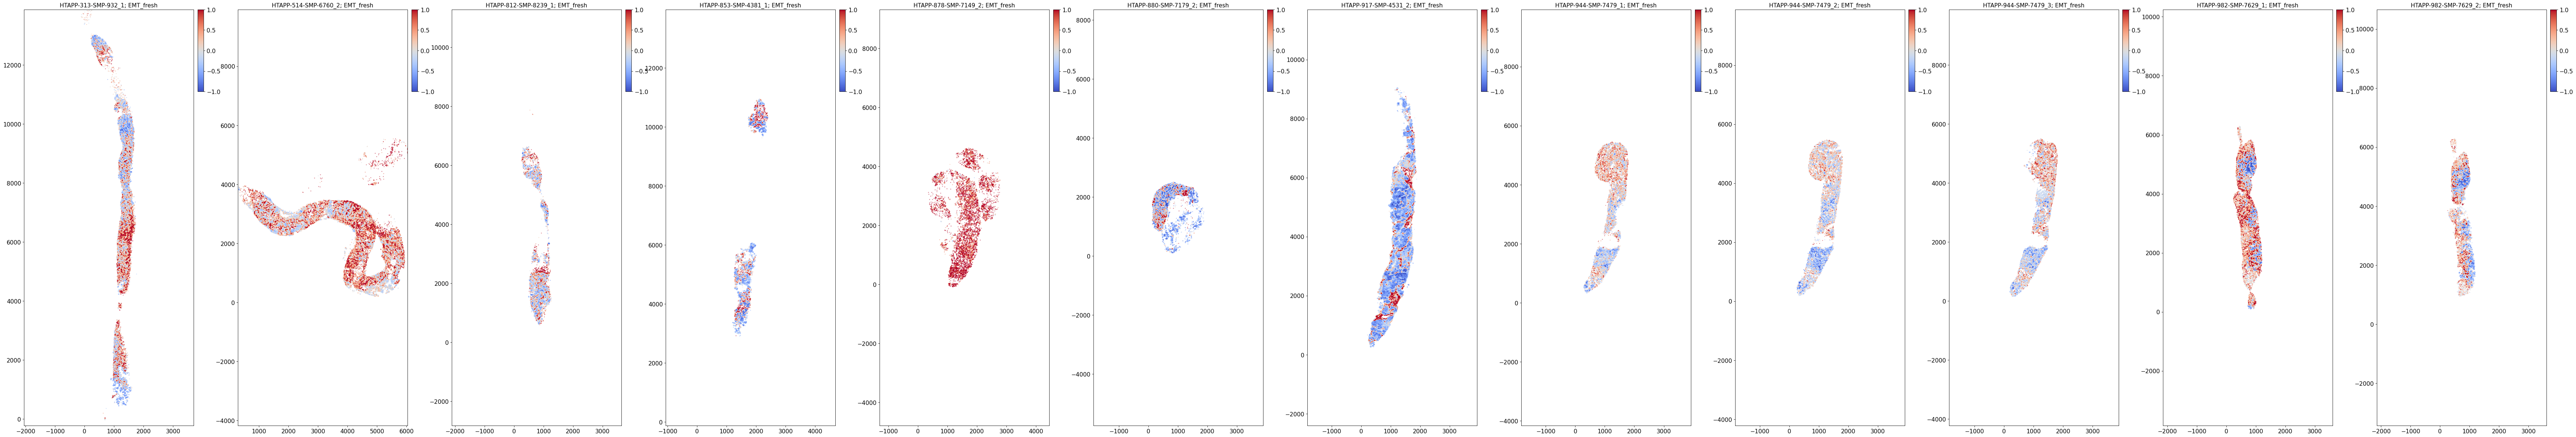

In [46]:
fig=tc.pl.scatter(adatas_combined_mal['merfish_bin'],group_key='sample_repl',keys=['EMT_fresh'],cmap="coolwarm",cmap_vmin_vmax=[-1,1],joint=True,padding=1.5,point_size=2,axsize=1e-3);
fig.savefig(combined_dir+'/scatter_merfish_bin_mal_EMT.pdf',bbox_inches='tight')

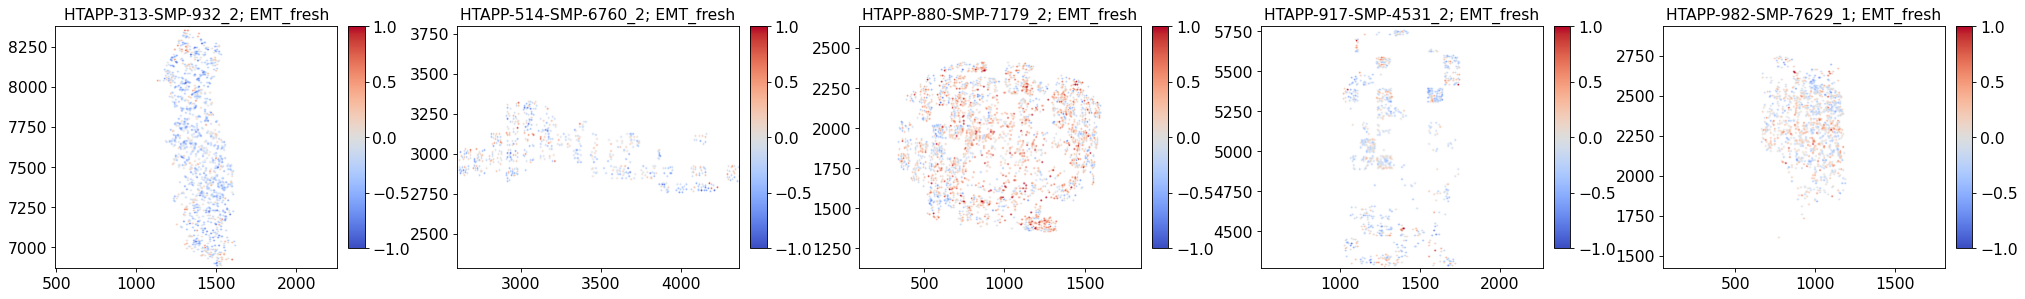

In [50]:
fig=tc.pl.scatter(adatas_combined_mal['exseq'],group_key='sample_repl',keys=['EMT_fresh'],cmap="coolwarm",cmap_vmin_vmax=[-1,1],joint=True,padding=1.5,point_size=2,axsize=2e-3);
fig.savefig(combined_dir+'/scatter_exseq_mal_EMT.pdf',bbox_inches='tight')

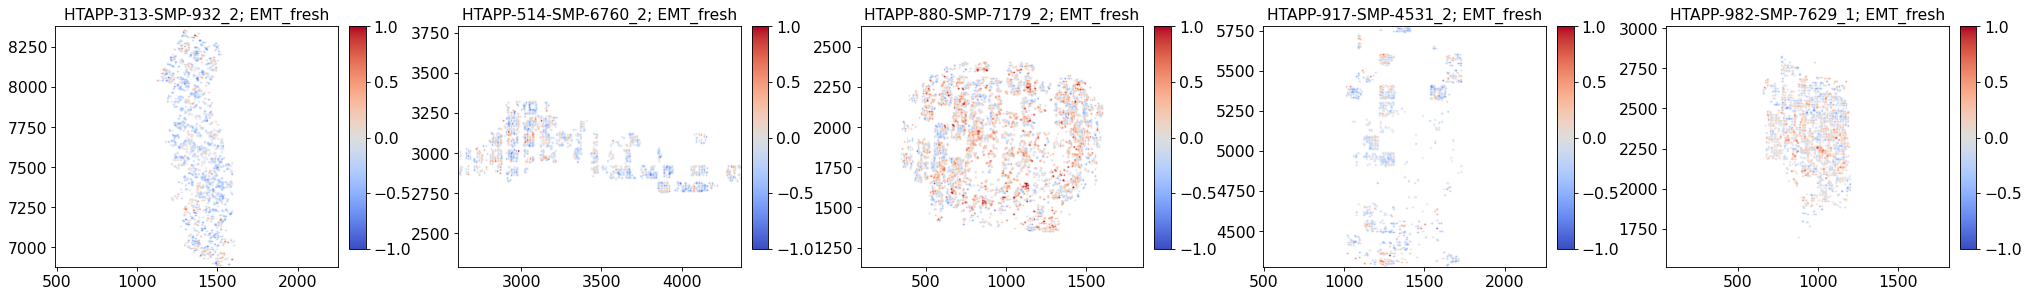

In [52]:
fig=tc.pl.scatter(adatas_combined_mal['exseq_bin'],group_key='sample_repl',keys=['EMT_fresh'],cmap="coolwarm",cmap_vmin_vmax=[-1,1],joint=True,padding=1.5,point_size=2,axsize=2e-3);
fig.savefig(combined_dir+'/scatter_exseq_bin_mal_EMT.pdf',bbox_inches='tight')

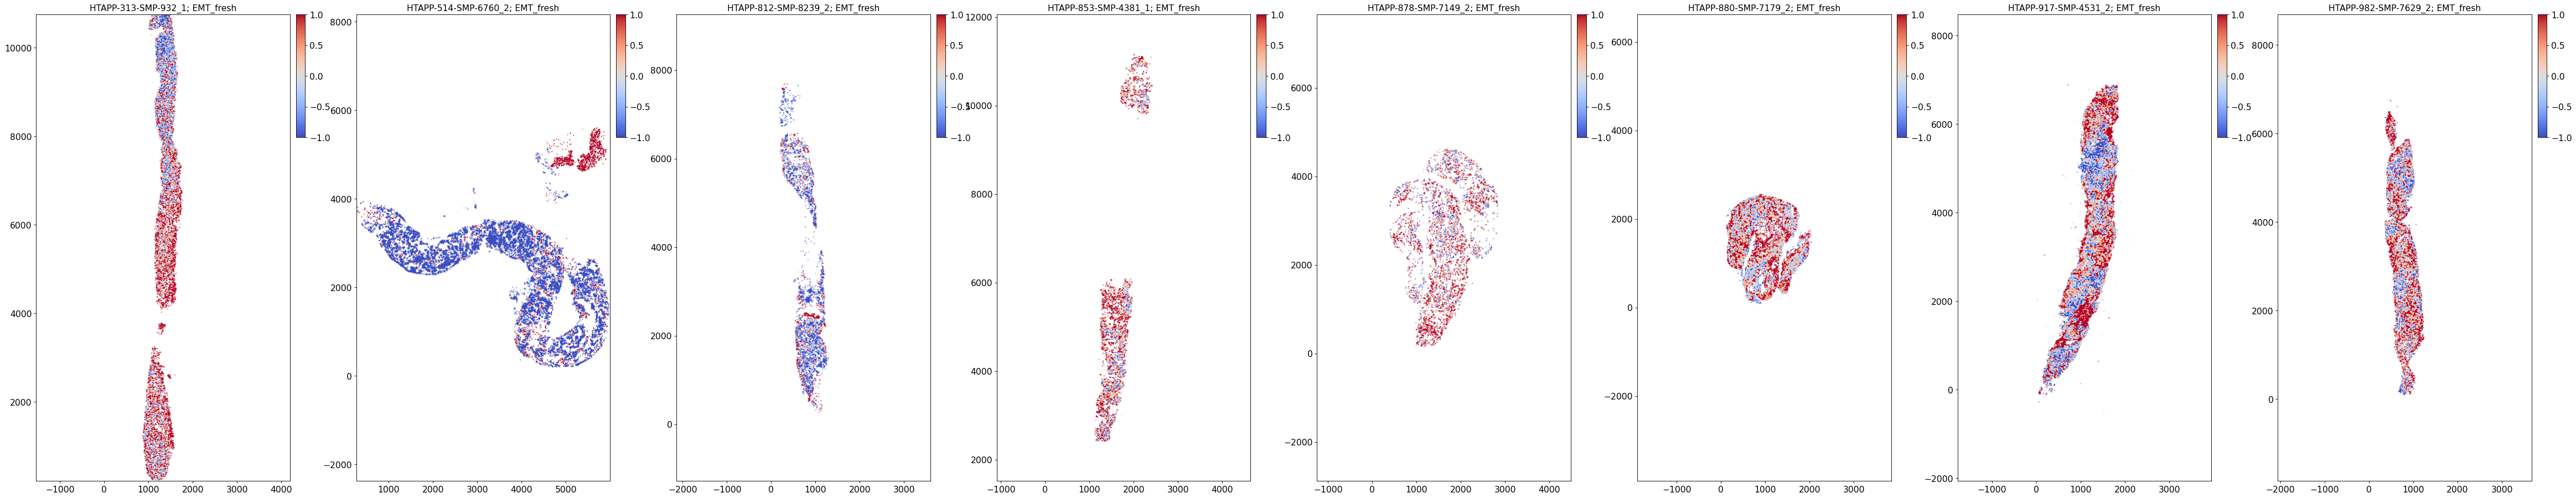

In [53]:
fig=tc.pl.scatter(adatas_combined_mal['codex'],group_key='sample_repl',keys=['EMT_fresh'],cmap="coolwarm",cmap_vmin_vmax=[-1,1],joint=True,padding=1.5,point_size=2,axsize=1e-3);
fig.savefig(combined_dir+'/scatter_codex_mal_EMT.pdf',bbox_inches='tight')

In [48]:
# write out obs to investigate ct composition association with EMT
for method in all_methods:
    adatas_combined_mal[method].obs.to_csv(combined_dir+"/"+method+"_mal_obs.tsv", sep="\t")
    adatas_combined[method].obs.to_csv(combined_dir+"/"+method+"_obs.tsv", sep="\t")